In [1]:
import numpy as np
import math as mp
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
gamma = 1
eta = 0.5
sigma = 5
beta_hh = 0.99
r = 0.01
beta = 1 /( 1.0 +r)
beta1 =1/( (1.0 +r* np.exp(30/(36.5*0.9)))) 
W = 1
power = ((1+eta)/(-gamma-eta))


/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/2291322681.py:6: RuntimeWarning: divide by zero encountered in log
  N = -(data_tau) - 1/np.log(beta*c)
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/2291322681.py:7: RuntimeWarning: divide by zero encountered in log
  tau1= -1/np.log(beta*c) - N
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/2291322681.py:9: RuntimeWarning: divide by zero encountered in log
  tau2= -1/np.log(beta1*c) - N


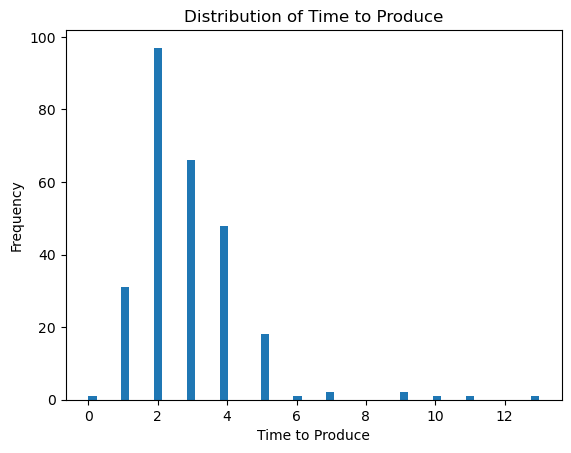

In [3]:
data=pd.read_csv('APP_data_usa_goods.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
data_tau=(data['invtCogsRatio']* 36.5/(30*0.1))
tau_diff = np.zeros(( 1000,1))
i = 0
for c in np.linspace(0, 0.99, 1000): 
    N = -(data_tau) - 1/np.log(beta*c) 
    tau1= -1/np.log(beta*c) - N
    tau1[tau1<0] = 0     
    tau2= -1/np.log(beta1*c) - N
    tau2[tau2<0] = 0    
    tau_diff[i] = np.mean(np.abs(tau1-tau2))
    i = i+1

min_val = np.min(np.abs(tau_diff-1))
argmins = np.where(np.abs(tau_diff-1) == min_val)[0]
argmins
c_list = np.linspace(0, 0.99, 1000)
c=c_list[argmins]
N=-data_tau - 1/np.log(beta*c) 
tau= -1/np.log(beta*c) - N
tau[tau<0] = 0  
tau_floor = np.floor(tau)
tau_ceil = np.ceil(tau)
tprod_ceil=  (beta*c)**tau_ceil * (tau_ceil + N)
tprod_floor=  (beta*c)**tau_floor * (tau_floor + N)
tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
tau[tau<0] = 0  
tprod = (beta*c)**tau * (tau + N)
plt.hist(tau, bins = 55, alpha=1, label='tau_noise')
plt.xlabel('Time to Produce')
plt.ylabel('Frequency')
plt.title('Distribution of Time to Produce')
plt.show()
tau = np.array(tau, dtype=int)

In [4]:

def consumption_function(P):
    return (P)**power
def euler_equation(P_0, P_1, beta_hh, r):
    consumption_growth_comp = (consumption_function(P_1) / consumption_function(P_0))**((gamma))
    price_growth_comp = (P_0 / P_1)
    wage_inflation = 1/(consumption_growth_comp / (price_growth_comp *  (beta_hh *   (1+r)) ))
    return wage_inflation
def price_inflation_ee(P_0, P_1, beta_hh, r):
    consumption_growth_comp = (consumption_function(P_1) / consumption_function(P_0))**((gamma))
    constants = (beta_hh * (1+r))
    price_inflation = 1/ (consumption_growth_comp / constants)
    return price_inflation

In [5]:
r = 0.01
shocky = 0.99
beta_org = (1 / (1 + 0.01))*c
tau= -1/np.log(beta_org) - N
tau[tau<0] = 0  
tau_floor = np.floor(tau)
tau_ceil = np.ceil(tau)
tprod_ceil=  beta_org**tau_ceil * (tau_ceil + N)
tprod_floor=  beta_org**tau_floor * (tau_floor + N)
tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
tau[tau<0] = 0 
tprod1=  np.array(beta_org**tau * (tau + N) )  
P0 = (np.sum(1/(tprod1)**(1-sigma)))**(1/(1-sigma)) 

beta_rep = (1 / (1 + r))*c
tau_rep= -1/np.log(beta_rep) - shocky* N
tau_rep[tau_rep<0] = 0  
tau_rep_floor = np.floor(tau_rep)
tau_rep_ceil = np.ceil(tau_rep)
tprod_ceil=  beta_rep**tau_rep_ceil * (tau_rep_ceil + shocky*N)
tprod_floor=  beta_rep**tau_rep_floor * (tau_rep_floor + shocky* N)
tau_rep[(tprod_ceil-tprod_floor)>0] = tau_rep_ceil[(tprod_ceil-tprod_floor)>0]
tau_rep[(tprod_ceil-tprod_floor)<0] = tau_rep_floor[(tprod_ceil-tprod_floor)<0]
tau_rep[tau_rep<0] = 0 
tprod_rep=  np.array(beta_rep**tau_rep * (tau_rep +  N) )  
Pend = (np.sum(1/(tprod_rep)**(1-sigma)))**(1/(1-sigma)) 

P = np.zeros((int(np.max(tau_rep))+2, 1))
P[0, 0] = P0
P[-1, 0] = P0


tau = tau.sort_values()
tau_rep = tau_rep.sort_values()
diff = tau-tau_rep
index_diff=tau_rep[diff !=0].index

In [6]:
tau_list = {}
tau_list[0] = np.array(tau)

for j in range(0, int(np.max(tau_rep)) + 1):
    tau1_temp = pd.Series(tau[tau > j])
    tau2_temp = pd.Series(tau_rep[tau_rep <= j])

    tau1_temp_df = tau1_temp.to_frame(name='t')
    tau1_temp_df['source'] = 'org'

    tau2_temp_df = tau2_temp.to_frame(name='t')
    tau2_temp_df['source'] = 'rep'

    t_temp = pd.concat([tau1_temp_df, tau2_temp_df])

    dup_indices = t_temp.index[t_temp.index.duplicated(keep=False)].unique()

    keep_rows = []

    for i in dup_indices:
        rows = t_temp.loc[[i]]
        N_temp = N.loc[[i]]
        t_org = rows[rows['source'] == 'org']['t'].values[0]
        t_rep = rows[rows['source'] == 'rep']['t'].values[0]

        tprod_org_temp = beta_org**t_org * (t_org + N_temp)
        tprod_rep_temp = beta_rep**t_rep * (t_rep + N_temp)
        if i ==j:
            tprod_rep_temp = beta_rep**t_rep * (t_rep +shocky* N_temp)

        # Keep only the row with the higher value
        if tprod_org_temp.values >= tprod_rep_temp.values:
            keep_rows.append(rows[rows['source'] == 'org'])
        else:
            keep_rows.append(rows[rows['source'] == 'rep'])

    # Drop all duplicates first
    t_temp = t_temp[~t_temp.index.isin(dup_indices)]

    # Add back only the best ones
    if keep_rows:
        t_temp = pd.concat([t_temp] + keep_rows)
    t_temp['N'] = N.loc[t_temp.index].values

    # Step 1: Add matching N values
    t_temp['N'] = N.loc[t_temp.index].values  # will align correctly by NAICS6 index

    # Step 2: Compute t_prod using vectorized logic
    beta_vec = t_temp['source'].map({'org': beta_org, 'rep': beta_rep})
    A_vec = np.where((t_temp['source'] == 'rep') & (t_temp['t'] == j), shocky, 1.0)
    t_temp['A'] = A_vec
    t_temp['t_prod'] = beta_vec ** t_temp['t'] * (t_temp['t'] +A_vec *  t_temp['N'])
    
    tprod_temp = t_temp['t_prod'].values

# Compute P[j+1, 0]
    P[j + 1, 0] = (np.sum(1 / (tprod_temp ** (1 - sigma)))) ** (1 / (1 - sigma))

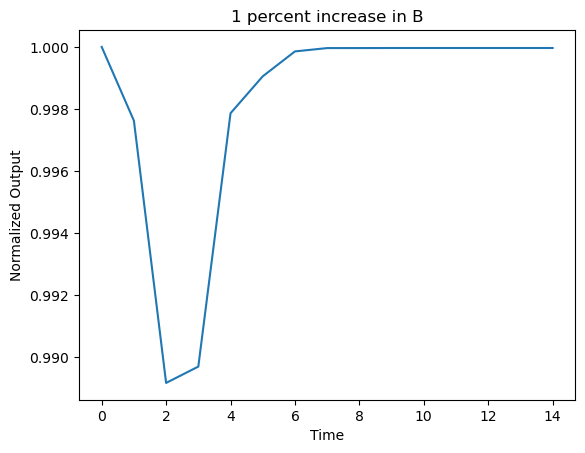

In [7]:
import matplotlib.pyplot as plt

plt.plot( (P)**power/P[0]**power)
plt.title('1 percent increase in B')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

In [8]:
P

array([[0.0372093 ],
       [0.03729807],
       [0.03761703],
       [0.037597  ],
       [0.03728908],
       [0.03724461],
       [0.03721469],
       [0.0372107 ],
       [0.03721067],
       [0.0372106 ],
       [0.0372106 ],
       [0.0372106 ],
       [0.0372106 ],
       [0.0372106 ],
       [0.0372106 ]])

In [9]:
wage_inflation = np.zeros(len(P)-1)
for i in range(len(P)-1):
    P_0 = P[i,0]
    P_1 = P[i+1,0]
    wage_inflation[i] =     euler_equation(P_0, P_1, beta_hh, r)

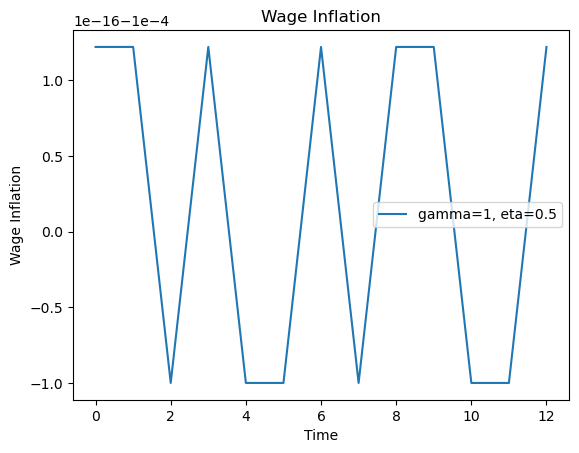

In [10]:
plt.plot(wage_inflation[:13]-1, label=f'gamma={gamma}, eta={eta}')
plt.title('Wage Inflation')
plt.xlabel('Time')
plt.ylabel('Wage Inflation')    
plt.legend()
plt.show()

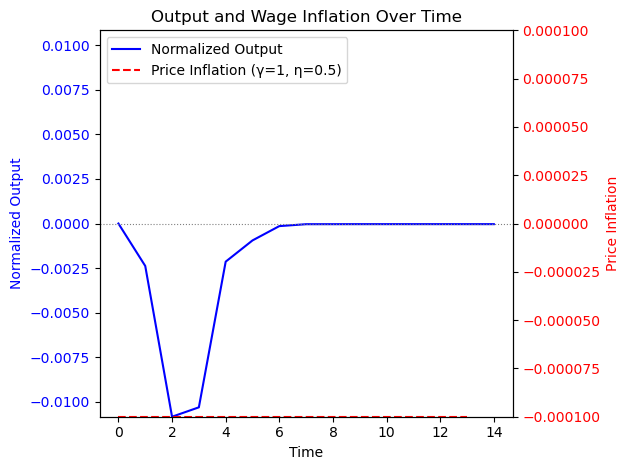

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# First plot data
normalized_output = (P)**power / P[0]**power - 1  # Center at 0

# Second plot data
wage_inflation = np.zeros(len(P)-1)
for i in range(len(P)-1):
    P_0 = P[i,0]
    P_1 = P[i+1,0]
    wage_inflation[i] = euler_equation(P_0, P_1, beta_hh, r)
wage_inflation_centered = wage_inflation - 1  # Center at 0

# Create figure and first axis
fig, ax1 = plt.subplots()

# Plot normalized output
ax1.plot(normalized_output, 'b-', label='Normalized Output')
ax1.set_xlabel('Time')
ax1.set_ylabel('Normalized Output', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Output and Wage Inflation Over Time')

# Create second y-axis
ax2 = ax1.twinx()
ax2.plot(range(len(wage_inflation_centered)), wage_inflation_centered, 'r--',
         label=f'Price Inflation (γ={gamma}, η={eta})')
ax2.set_ylabel('Price Inflation', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# --- Center both y-axes at zero ---
# Get limits and compute symmetrical bounds
y1_max = max(abs(np.min(normalized_output)), abs(np.max(normalized_output)))
y2_max = max(abs(np.min(wage_inflation_centered)), abs(np.max(wage_inflation_centered)))

ax1.set_ylim(-y1_max, y1_max)
ax2.set_ylim(-y2_max, y2_max)

# Optional: combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.axhline(0, color='gray', linestyle=':', linewidth=0.8)  # horizontal line at y=0
plt.tight_layout()
plt.show()



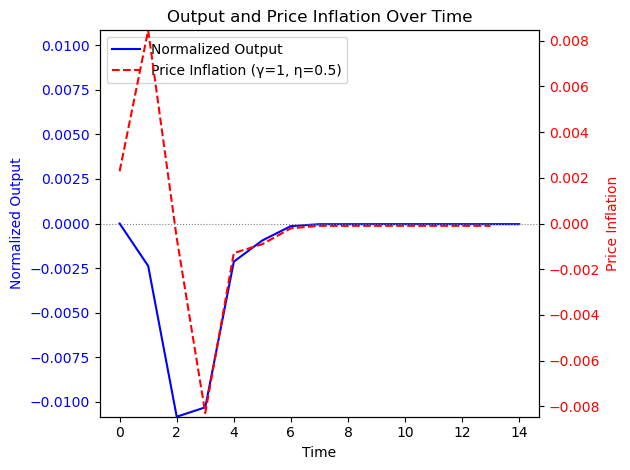

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# First plot data
normalized_output = (P)**power / P[0]**power - 1  # Center at 0

# Second plot data
price_inflation_list = np.zeros(len(P)-1)
for i in range(len(P)-1):
    P_0 = P[i,0]
    P_1 = P[i+1,0]
    price_inflation_list[i] = price_inflation_ee(P_0, P_1, beta_hh, r)
price_inflation_centered = price_inflation_list - 1  # Center at 0

# Create figure and first axis
fig, ax1 = plt.subplots()

# Plot normalized output
ax1.plot(normalized_output, 'b-', label='Normalized Output')
ax1.set_xlabel('Time')
ax1.set_ylabel('Normalized Output', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Output and Price Inflation Over Time')

# Create second y-axis
ax2 = ax1.twinx()
ax2.plot(range(len(price_inflation_centered)), price_inflation_centered, 'r--',
         label=f'Price Inflation (γ={gamma}, η={eta})')
ax2.set_ylabel('Price Inflation', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# --- Center both y-axes at zero ---
# Get limits and compute symmetrical bounds
y1_max = max(abs(np.min(normalized_output)), abs(np.max(normalized_output)))
y2_max = max(abs(np.min(price_inflation_centered)), abs(np.max(price_inflation_centered)))

ax1.set_ylim(-y1_max, y1_max)
ax2.set_ylim(-y2_max, y2_max)

# Optional: combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.axhline(0, color='gray', linestyle=':', linewidth=0.8)  # horizontal line at y=0
plt.tight_layout()
plt.show()

In [13]:
np.prod(price_inflation_list)

0.9986356616711037

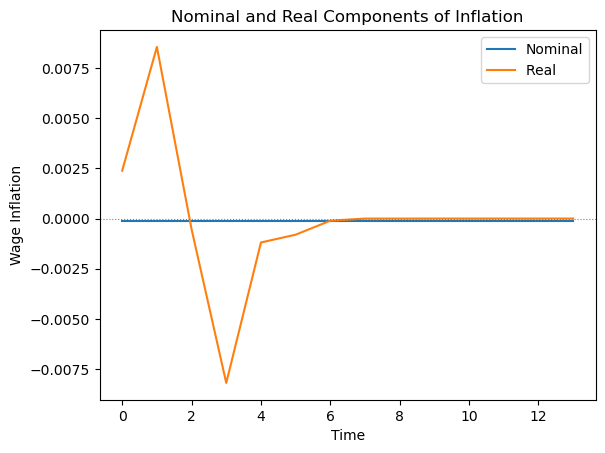

In [14]:
# Second plot data
nominal = np.zeros(len(P)-1)
for i in range(len(P)-1):
    P_0 = P[i]
    P_1 = P[i+1]
    nominal[i] = euler_equation(P_0, P_1, beta_hh, r)
nominal = nominal - 1  # Center at 0

# Second plot data
real = np.zeros(len(P)-1)
for i in range(len(P)-1):
    P_0 = P[i]
    P_1 = P[i+1]
    real[i] = P_1/P_0
real = real - 1  # Center at 0
plt.plot(nominal, label='Nominal')
plt.plot(real, label='Real  ')
plt.title('Nominal and Real Components of Inflation')
plt.xlabel('Time')
plt.ylabel('Wage Inflation')
plt.legend()
plt.axhline(0, color='gray', linestyle=':', linewidth=0.8)  # horizontal line at y=0
plt.show()  

In [15]:
np.prod(wage_inflation)

0.9986009096361008

In [ ]:
r_arrange = np.linspace(0.01, 0.016    , 100)
P = np.zeros((20, 100))
k=0
shock = 0.97
tau_list = {}
index_diff_list = {}
for r in r_arrange: 
    beta_org = (1 / (1 + 0.01))*c
    tau= -1/np.log(beta_org) - N
    tau[tau<0] = 0  
    tau_floor = np.floor(tau)
    tau_ceil = np.ceil(tau)
    tprod_ceil=  beta_org**tau_ceil * (tau_ceil + N)
    tprod_floor=  beta_org**tau_floor * (tau_floor + N)
    tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
    tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
    tau[tau<0] = 0 
    tprod1=  np.array(beta_org**tau * (tau + N) )  
    P0 = (np.sum(1/(tprod1)**(1-sigma)))**(1/(1-sigma)) 

    beta_rep = (1 / (1 + r))*c
    tau_rep= -1/np.log(beta_rep) - shock*N
    tau_rep[tau_rep<0] = 0  
    tau_rep_floor = np.floor(tau_rep)
    tau_rep_ceil = np.ceil(tau_rep)
    tprod_ceil=  beta_rep**tau_rep_ceil * (tau_rep_ceil +  shock*N)
    tprod_floor=  beta_rep**tau_rep_floor * (tau_rep_floor +  shock*N)
    tau_rep[(tprod_ceil-tprod_floor)>0] = tau_rep_ceil[(tprod_ceil-tprod_floor)>0]
    tau_rep[(tprod_ceil-tprod_floor)<0] = tau_rep_floor[(tprod_ceil-tprod_floor)<0]
    tau_rep[tau_rep<0] = 0 

    P[0, k] = P0

    tau = tau.sort_values()
    tau_rep = tau_rep.sort_values()
    tau_list[k] = np.array(tau_rep)
    diff = tau-tau_rep
    index_diff=tau_rep[diff !=0].index
    index_diff_list[k] = np.sum(index_diff!=0)

    for j in range(0, int(np.max(tau_rep)) + 1):
        tau1_temp = pd.Series(tau[tau > j])
        tau2_temp = pd.Series(tau_rep[tau_rep <= j])

        tau1_temp_df = tau1_temp.to_frame(name='t')
        tau1_temp_df['source'] = 'org'

        tau2_temp_df = tau2_temp.to_frame(name='t')
        tau2_temp_df['source'] = 'rep'

        t_temp = pd.concat([tau1_temp_df, tau2_temp_df])

        dup_indices = t_temp.index[t_temp.index.duplicated(keep=False)].unique()

        keep_rows = []

        for i in dup_indices:
            rows = t_temp.loc[[i]]
            N_temp = N.loc[[i]]
            t_org = rows[rows['source'] == 'org']['t'].values[0]
            t_rep = rows[rows['source'] == 'rep']['t'].values[0]
            if j < t_org:
                tprod_org_temp = beta_rep**j*beta_org**(t_org-j) * (t_org + N_temp)
            else:
                tprod_org_temp = beta_org**t_org * (t_org + N_temp)
            tprod_rep_temp = beta_rep**t_rep * (t_rep + N_temp)
            if i == j:
                tprod_rep_temp = beta_rep**t_rep * (t_rep +  shock* N_temp)

            # Keep only the row with the higher value
            if tprod_org_temp.values >= tprod_rep_temp.values:
                keep_rows.append(rows[rows['source'] == 'org'])
            else:
                keep_rows.append(rows[rows['source'] == 'rep'])

        # Drop all duplicates first
        t_temp = t_temp[~t_temp.index.isin(dup_indices)]

        # Add back only the best ones
        if keep_rows:
            t_temp = pd.concat([t_temp] + keep_rows)
        t_temp['N'] = N.loc[t_temp.index].values

        # Step 1: Add matching N values
        t_temp['N'] = N.loc[t_temp.index].values  # will align correctly by NAICS6 index

        # Step 2: Compute t_prod using vectorized logic
        beta_vec = t_temp['source'].map({'org': beta_org, 'rep': beta_rep})
        A_vec = np.where((t_temp['source'] == 'rep') & (t_temp['t'] == j), shock, 1.0)
        t_temp['A'] = A_vec
        t_temp['t_prod'] =  beta_vec ** t_temp['t'] * (t_temp['t'] + A_vec*t_temp['N'])
        
        tprod_temp = t_temp['t_prod'].values
        P[j + 1, k] = (np.sum(1 / (tprod_temp ** (1 - sigma)))) ** (1 / (1 - sigma))


    tau_rep= -1/np.log(beta_rep) - N
    tau_rep[tau_rep<0] = 0  
    tau_rep_floor = np.floor(tau_rep)
    tau_rep_ceil = np.ceil(tau_rep)
    tprod_ceil=  beta_rep**tau_rep_ceil * (tau_rep_ceil +  N)
    tprod_floor=  beta_rep**tau_rep_floor * (tau_rep_floor +  N)
    tau_rep[(tprod_ceil-tprod_floor)>0] = tau_rep_ceil[(tprod_ceil-tprod_floor)>0]
    tau_rep[(tprod_ceil-tprod_floor)<0] = tau_rep_floor[(tprod_ceil-tprod_floor)<0]
    tau_rep[tau_rep<0] = 0 
    tprod_rep=  np.array(beta_rep**tau_rep * (tau_rep +  N) )  
    P1 = (np.sum(1/(tprod_rep)**(1-sigma)))**(1/(1-sigma)) 
    P[j+1, k] = P1

    k = k+1
    print(k)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [17]:
k=0
deviation_gap = np.zeros((100, 1))
for r in r_arrange: 
    P_temp = P[:,k]
    P_temp_no_zeros = P_temp[P_temp != 0]

    Y = np.zeros((len(P_temp_no_zeros), 1))
    Y[0] = P_temp_no_zeros[0]**power /P_temp_no_zeros[0]**power
    Y[1:,0] = P_temp_no_zeros[1:]**power /P_temp_no_zeros[0]**power
    wage_inflation = np.zeros(len(P_temp_no_zeros)-1)

    for i in range(len(P_temp_no_zeros)-1):
        P_0 = P_temp_no_zeros[i]
        P_1 = P_temp_no_zeros[i+1]
        wage_inflation[i] =     price_inflation_ee(P_0, P_1, beta_hh, r)

    deviation_gap[k] = np.sum((Y - 1 )**2) +  1000*np.sum((wage_inflation- 1 )**2) 
    k = k+1

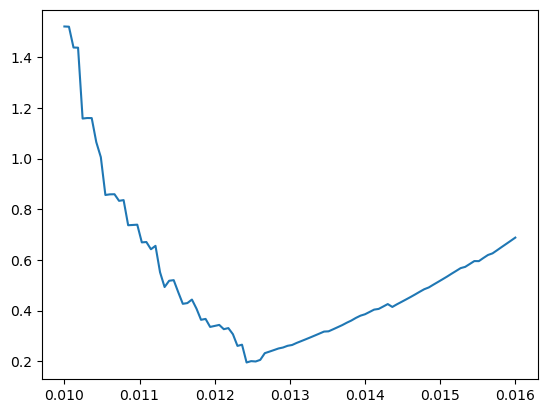

In [18]:
plt.plot(r_arrange,deviation_gap)
plt.show()

In [19]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
r_arrange[argmins_gap]

array([0.01242424])

/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/1964428357.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot( P[:,argmins_gap]**power/ P[0, 0]**power)


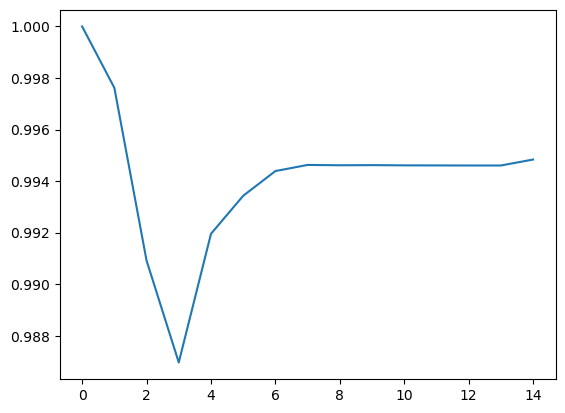

In [20]:
plt.plot( P[:,argmins_gap]**power/ P[0, 0]**power)
plt.show()

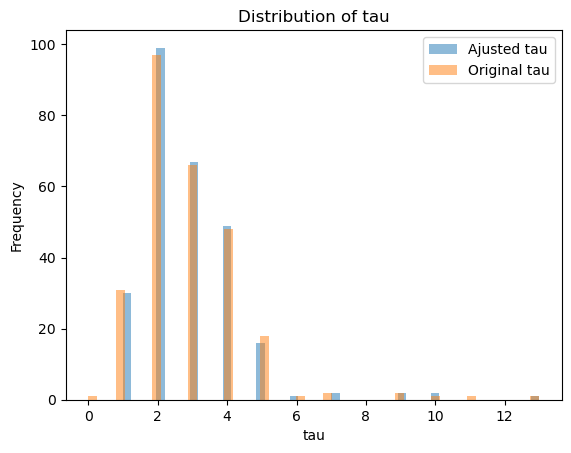

In [21]:
plt.hist(tau_list[argmins_gap[0]], alpha=0.5, bins=50, label='Ajusted tau')
plt.hist(tau, bins=50, alpha=0.5, label='Original tau')
plt.title('Distribution of tau')
plt.xlabel('tau')
plt.ylabel('Frequency')
plt.legend()    
plt.show()

In [22]:
beta_rep = (1 / (1 + 0.01))*c
tau_rep= -1/np.log(beta_rep) - shock*N
tau_rep[tau_rep<0] = 0  
tau_rep_floor = np.floor(tau_rep)
tau_rep_ceil = np.ceil(tau_rep)
tprod_ceil=  beta_rep**tau_rep_ceil * (tau_rep_ceil +  shock*N)
tprod_floor=  beta_rep**tau_rep_floor * (tau_rep_floor +  shock*N)
tau_rep[(tprod_ceil-tprod_floor)>0] = tau_rep_ceil[(tprod_ceil-tprod_floor)>0]
tau_rep[(tprod_ceil-tprod_floor)<0] = tau_rep_floor[(tprod_ceil-tprod_floor)<0]
tau_rep[tau_rep<0] = 0

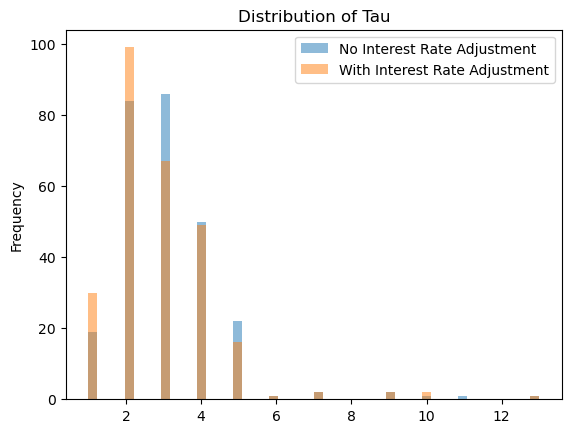

In [23]:
plt.hist(tau_rep, alpha=0.5, bins=50, label='No Interest Rate Adjustment')
plt.hist(tau_list[argmins_gap[0]], alpha=0.5, bins=50, label='With Interest Rate Adjustment')
plt.title('Distribution of Tau')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [24]:
wage_inflation = np.zeros(len(P[:,argmins_gap])-1)

for i in range(len(P[:,argmins_gap])-1):
    P_0 = P[:,argmins_gap][i]
    P_1 = P[:,argmins_gap][i+1]
    wage_inflation[i] =     price_inflation_ee(P_0, P_1, beta_hh, r_arrange[argmins_gap])

/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/1747820775.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  return (P)**power
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/1747820775.py:9: RuntimeWarning: invalid value encountered in divide
  consumption_growth_comp = (consumption_function(P_1) / consumption_function(P_0))**((gamma))


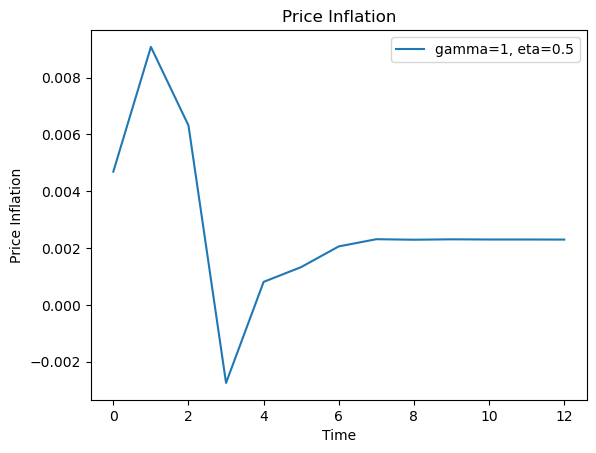

In [25]:
plt.plot(wage_inflation[:13]-1, label=f'gamma={gamma}, eta={eta}')
plt.title('Price Inflation')
plt.xlabel('Time')
plt.ylabel('Price Inflation')
plt.legend()
plt.show()

In [26]:
k=0
deviation_gap = np.zeros((100, 1))
for r in r_arrange: 
    P_temp = P[:,k]
    P_temp_no_zeros = P_temp[P_temp != 0]
    Y = np.zeros((len(P_temp_no_zeros), 1))
    Y[0] = P_temp_no_zeros[0]**power / P_temp_no_zeros[0]**power
    Y[1:,0] = P_temp_no_zeros[1:]**power /P_temp_no_zeros[0]**power
    wage_inflation = np.zeros(len(P_temp_no_zeros)-1)

    for i in range(len(P_temp_no_zeros)-1):
        P_0 = P_temp_no_zeros[i]
        P_1 = P_temp_no_zeros[i+1]
        wage_inflation[i] =     price_inflation_ee(P_0, P_1, beta_hh, r)

    deviation_gap[k] = np.sum((Y - 1 )**2) + np.sum((wage_inflation- 1 )**2) 
    k = k+1

In [27]:
k=0
deviation_gap_inflation = np.zeros((100, 1))
for r in r_arrange: 
    P_temp = P[:,k]
    P_temp_no_zeros = P_temp[P_temp != 0]
    Y = np.zeros((len(P_temp_no_zeros), 1))
    wage_inflation = np.zeros(len(P_temp_no_zeros)-1)

    for i in range(len(P_temp_no_zeros)-1):
        P_0 = P_temp_no_zeros[i]
        P_1 = P_temp_no_zeros[i+1]
        wage_inflation[i] =     price_inflation_ee(P_0, P_1, beta_hh, r)

    deviation_gap_inflation[k] = np.sum((wage_inflation- 1 )**2) 
    k = k+1

In [28]:
k=0
deviation_gap_output = np.zeros((100, 1))
for r in r_arrange: 
    P_temp = P[:,k]
    P_temp_no_zeros = P_temp[P_temp != 0]
    Y = np.zeros((len(P_temp_no_zeros), 1))
    Y[0] = P_temp_no_zeros[0]**power / P_temp_no_zeros[0]**power
    Y[1:,0] = P_temp_no_zeros[1:]**power /P_temp_no_zeros[0]**power


    deviation_gap_output[k] = np.sum((Y - 1 )**2)
    k = k+1

In [29]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap_output = np.where(deviation_gap_output == np.min(deviation_gap_output))[0]
argmins_gap_inflation = np.where(deviation_gap_inflation == np.min(deviation_gap_inflation))[0]

In [30]:
print(r_arrange[argmins_gap])
print(r_arrange[argmins_gap_output])
print(r_arrange[argmins_gap_inflation])

[0.01242424]
[0.01242424]
[0.01242424]


/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/2767497975.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / P[:,argmins_gap] * P[0, 0])
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/2767497975.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / P[:,argmins_gap_output] * P[0, 0])
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/2767497975.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / P[:,argmins_gap_inflation] * P[0, 0])


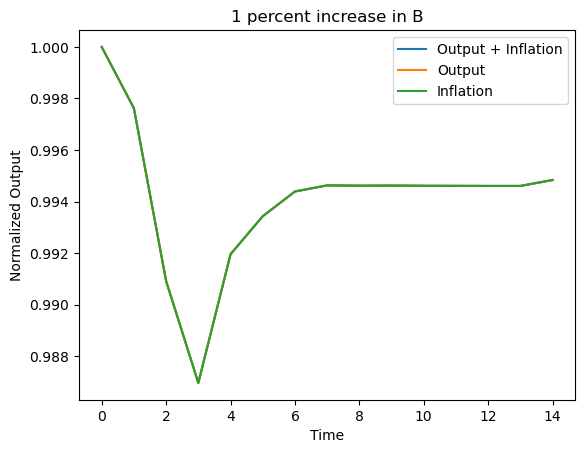

In [31]:
plt.plot(1 / P[:,argmins_gap] * P[0, 0])
plt.plot(1 / P[:,argmins_gap_output] * P[0, 0])
plt.plot(1 / P[:,argmins_gap_inflation] * P[0, 0])
plt.legend(['Output + Inflation', 'Output', 'Inflation'])
plt.title('1 percent increase in B')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

In [32]:
wage_inflation = np.zeros(len(P[:,argmins_gap])-1)

for i in range(len(P[:,argmins_gap])-1):
    P_0 = P[:,argmins_gap][i]
    P_1 = P[:,argmins_gap][i+1]
    wage_inflation[i] =     price_inflation_ee(P_0, P_1, beta_hh, r_arrange[argmins_gap])

wage_inflation_output = np.zeros(len(P[:,argmins_gap_output])-1)

for i in range(len(P[:,argmins_gap_output])-1):
    P_0 = P[:,argmins_gap_output][i]
    P_1 = P[:,argmins_gap_output][i+1]
    wage_inflation_output[i] =     price_inflation_ee(P_0, P_1, beta_hh, r_arrange[argmins_gap_output])

wage_inflation_inflation = np.zeros(len(P[:,argmins_gap_inflation])-1)

for i in range(len(P[:,argmins_gap_inflation])-1):
    P_0 = P[:,argmins_gap_inflation][i]
    P_1 = P[:,argmins_gap_inflation][i+1]
    wage_inflation_inflation[i] =     price_inflation_ee(P_0, P_1, beta_hh, r_arrange[argmins_gap_inflation])

/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/1747820775.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  return (P)**power
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/1747820775.py:9: RuntimeWarning: invalid value encountered in divide
  consumption_growth_comp = (consumption_function(P_1) / consumption_function(P_0))**((gamma))


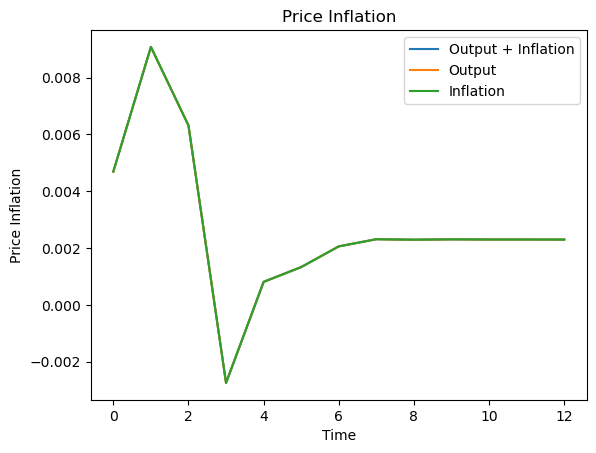

In [33]:
plt.plot(wage_inflation[:13]-1, label=f'Output + Inflation')
plt.plot(wage_inflation_output[:13]-1, label=f'Output')
plt.plot(wage_inflation_inflation[:13]-1, label=f'Inflation')
plt.title('Price Inflation')
plt.xlabel('Time')
plt.ylabel('Price Inflation')
plt.legend()
plt.show()

/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/1747820775.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  return (P)**power
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/1747820775.py:5: RuntimeWarning: divide by zero encountered in divide
  price_growth_comp = (P_0 / P_1)
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/1747820775.py:6: RuntimeWarning: invalid value encountered in divide
  wage_inflation = 1/(consumption_growth_comp / (price_growth_comp *  (beta_hh *   (1+r)) ))
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/1747820775.py:4: RuntimeWarning: invalid value encountered in divide
  consumption_growth_comp = (consumption_function(P_1) / consumption_function(P_0))**((gamma))
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_4570/1747820775.py:5: RuntimeWarning: invalid value encountered in divide
  price_growth_comp = (P_0 / P_1)
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipyk

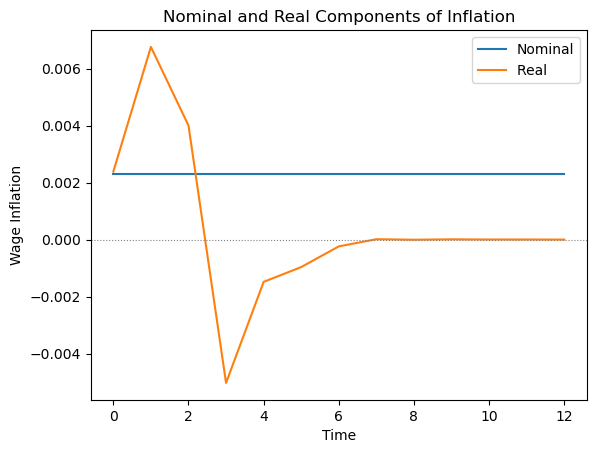

In [34]:
# Second plot data
nominal = np.zeros(len(P[:,argmins_gap])-1)
for i in range(len(P[:,argmins_gap])-1):
    P_0 = P[i,argmins_gap]
    P_1 = P[i+1,argmins_gap]
    nominal[i] = euler_equation(P_0, P_1, beta_hh,r_arrange[argmins_gap])
nominal = nominal - 1  # Center at 0

# Second plot data
real = np.zeros(len(P[:,argmins_gap])-1)
for i in range(len(P[:,argmins_gap])-1):
    P_0 = P[i,argmins_gap]
    P_1 = P[i+1,argmins_gap]
    real[i] = P_1/P_0
real = real - 1  # Center at 0
plt.plot(nominal[:13], label='Nominal')
plt.plot(real[:13], label='Real  ')
plt.title('Nominal and Real Components of Inflation')
plt.xlabel('Time')
plt.ylabel('Wage Inflation')
plt.legend()
plt.axhline(0, color='gray', linestyle=':', linewidth=0.8)  # horizontal line at y=0
plt.show()  